In [1]:
import math
import ctREFPROP.ctREFPROP as ct
import os
import numpy as np
import matplotlib.pyplot as plt

# Hack for my installation
os.environ['RPPREFIX'] = r'C:\\Program Files (x86)\REFPROP'

root = os.environ['RPPREFIX']
#r = ct.REFPROPFunctionLibrary(os.path.join(root, 'refprop.dll'))
r = ct.REFPROPFunctionLibrary(os.path.join(root, 'REFPRP64.dll'))
r.SETPATHdll(root)

In [2]:
fuel_type='ethane.FLD'
amb_type='nitrogen.FLD'
mix_list=fuel_type+"|"+amb_type
ierr, herr = r.GERG08dll(2,0)
if ierr !=0:
    raise ValueError(str(ierr) + ':' + herr)

r.FLAGSdll('GERG',1)
ierr, herr = r.SETUPdll(2,mix_list,'HMX.BNC','DEF')
if ierr !=0:
    raise ValueError(str(ierr) + ':' + herr)
    
#r.FLAGSdll('AGA8',0)
    

iUnits = 0 # in kPa
iMass = 0
iFlag = 1
T = 0
D = 0


dX = 0.01
xf = np.arange(0,1+dX,dX)
TempRange = np.arange(100,305,1)
satP = np.zeros(TempRange.size)
x=1
z=[x,(1-x)]
i=-1
for T in TempRange:
    i+=1
    satprops = r.SATTdll(T,z,2)
    satP[i] = satprops.P
    


CriT = np.zeros(xf.size)
CP_T = np.zeros(xf.size)
CriP = np.zeros(xf.size)
CP_P = np.zeros(xf.size)
CP_P_2 = np.zeros(xf.size)
CP_T_2 = np.zeros(xf.size)
CP_T_error = np.zeros(xf.size)
CP_P_error = np.zeros(xf.size)
CriTP = np.zeros(xf.size)
CriPT = np.zeros(xf.size)
#ALL = r.MAXTdll(z)
i=-1


## MAXPdll good subroutine for finding max pressure along the saturation line


for x in xf:
    i+=1
    z=[x,(1-x)]
    CriticalProp = r.CRTPNTdll(z,0,0)
    r.FLAGSdll('Splines off',1)
    if CriticalProp.ierr == 0:
        CP_T[i] = CriticalProp.Tc
        CP_P[i] = CriticalProp.Pc
    else: 
        CP_T_error[i] = CriticalProp.Tc
        CP_P_error[i] = CriticalProp.Pc
        CP_T[i] = None
        CP_P[i] = None

    #print("%i%s%i" % (i,'/',xf.size))


i=-1
for x in xf:
    i+=1
    z=[x,(1-x)]
    ierr, herr = r.SATSPLNdll(z)  # turns splines on
    ALL = r.ALLPROPSdll('TMAXT',iUnits,iMass,iFlag,T,D,z)
    SubALL = ALL[0]
    Cri = SubALL[0]
    CriT[i] = Cri
    ALL = r.ALLPROPSdll('PMAXT',iUnits,iMass,iFlag,T,D,z)
    SubALL = ALL[0]
    Cri = SubALL[0]
    CriTP[i] = Cri
    #if x<0.43 and x > 0.05: # added because data is sketchy below 0.1
        #CP_P[i] = None ## ALSO ZERO OUT CRITICAL PRESSURE
        #CP_T[i] = None ## ALSO ZERO OUT CRITICAL TEMPERATURE
        
    if x>0.43: # added because data is sketchy below 0.1
        ALL = r.ALLPROPSdll('PMAXP',iUnits,iMass,iFlag,T,D,z)
        SubALL = ALL[0]
        Cri = SubALL[0]
        if ALL.ierr == 0:
            CriP[i] = Cri
        ALL = r.ALLPROPSdll('TMAXP',iUnits,iMass,iFlag,T,D,z)
        SubALL = ALL[0]
        Cri = SubALL[0]
        if ALL.ierr == 0:
            CriPT[i] = Cri
    else:
        CriP[i] = None
        CriPT[i] = None
        CP_P[i] = None ## ALSO ZERO OUT CRITICAL PRESSURE
        CP_T[i] = None ## ALSO ZERO OUT CRITICAL TEMPERATURE
    ALL = r.ALLPROPSdll('PCEST',iUnits,iMass,iFlag,T,D,z)
    SubALL = ALL[0]
    Crit = SubALL[0]
    CP_P_2[i] = Crit
    ALL = r.ALLPROPSdll('TCEST',iUnits,iMass,iFlag,T,D,z)
    SubALL = ALL[0]
    Crit = SubALL[0]
    CP_T_2[i] = Crit
    
    

    
        

## Figure 4

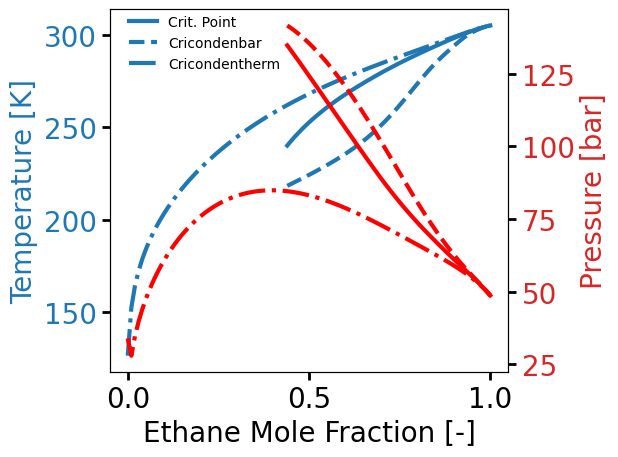

In [3]:
import matplotlib.pyplot as plt

SMALL_SIZE = 14
MEDIUM_SIZE = 14
BIGGER_SIZE = 20

fig, ax1 = plt.subplots()

fontsz = BIGGER_SIZE
color = 'tab:blue'
ax1.set_ylabel('Temperature [K]', color=color,fontsize=fontsz)  # we already handled the x-label with ax1
ax1.plot(xf, CP_T, color=color,linewidth=3)
ax1.plot(xf, CriPT, '--',color=color,linewidth=3)
ax1.plot(xf, CriT, '-.',color=color,linewidth=3)
ax1.set_xlabel('Ethane Mole Fraction [-]',fontsize=fontsz)
ax1.tick_params(axis='x', labelsize=fontsz)
ax1.tick_params(axis='y', labelcolor=color)
ax1.tick_params(axis='y', labelsize=fontsz)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.tick_params(axis='y', labelsize=fontsz)
ax2.set_ylabel('Pressure [bar]', color=color,fontsize=fontsz)
ax2.plot(xf, CP_P/100, 'r',linewidth=3)
ax2.plot(xf, CriP/100, 'r--',linewidth=3)
ax2.plot(xf, CriTP/100, 'r-.',linewidth=3)
ax2.tick_params(axis='y', labelcolor=color)
fig.legend(['Crit. Point','Cricondenbar','Cricondentherm'],bbox_to_anchor=(-0.025, 0.47, 0.5, 0.5),fontsize=10,frameon=False)
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
font = {'family' : 'normal',
        'weight' : 'normal'}
ax1.tick_params(direction='out', length=6, width=2)
ax2.tick_params(direction='out', length=6, width=2)
plt.rc('font', **font)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()




